In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
# Load the dataset
df = pd.read_csv(r"E:\DSBDAL\DSBDALExam DataSets\DSBDALExam DataSets\Adult\adult_dataset.csv")

# Display first few rows
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [47]:
print(df.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')


In [48]:
# Before outlier removal, check the shape of the data
print("Shape before outlier removal:", df.shape)


Shape before outlier removal: (48842, 15)


In [49]:
# Step 1: Check for missing values and '?' entries
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
              'marital-status', 'occupation', 'relationship', 'race', 'gender',
              'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Check for '?' entries
print("Question Mark Entries:\n", (df == '?').sum())

# Replace '?' with NaN
df.replace(' ?', np.nan, inplace=True)

# Drop rows with NaN values
df.dropna(inplace=True)

# Check if any missing values remain
print("Missing Values after cleanup:\n", df.isnull().sum())


Missing Values:
 age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64
Question Mark Entries:
 age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64
Missing Values after cleanup:
 age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain     

In [50]:
# Step 2: Check for any negative values in the numerical columns
numeric_cols = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check for negative values in numeric columns
print("Negative Values:\n", (df[numeric_cols].select_dtypes(include='number') < 0).sum())


Negative Values:
 age                0
fnlwgt             0
educational-num    0
capital-gain       0
capital-loss       0
hours-per-week     0
dtype: int64


In [55]:
# Step 3: Impute missing values for numeric columns with the median
from sklearn.impute import SimpleImputer

# Define numeric columns for imputation
numeric_cols = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
imputer = SimpleImputer(strategy='median')

# Impute missing values
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Impute missing categorical columns with the mode
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']
# Impute categorical columns with the mode
for col in categorical_cols:
    mode_value = df[col].mode()
    if not mode_value.empty:
        df[col] = df[col].fillna(mode_value[0])  # Avoid inplace=True
    else:
        print(f"Warning: No mode found for column '{col}', skipping imputation.")


# Check for missing values after imputation
# Check for missing values after imputation
print("Missing values after categorical imputation:\n", df.isna().sum())



Missing values after categorical imputation:
 age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64


In [56]:
# Step 4: Handle outliers in the numeric columns
outlier_columns = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']

# Set a more lenient threshold for outlier detection (2.5 * IQR)
outlier_removed_count = {}

for col in outlier_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 2.5 * IQR  # Relax the threshold to 2.5 * IQR
    upper = Q3 + 2.5 * IQR

    # Check how many rows are outliers for the column
    outlier_mask = df[col].between(lower, upper)
    outlier_removed_count[col] = df.shape[0] - outlier_mask.sum()

    # Apply the outlier mask
    df = df[outlier_mask]

print(f"Rows removed for each numeric column due to outliers: {outlier_removed_count}")
print("Shape after outlier removal:", df.shape)


Rows removed for each numeric column due to outliers: {'age': np.int64(0), 'capital-gain': np.int64(0), 'capital-loss': np.int64(0), 'hours-per-week': np.int64(3078)}
Shape after outlier removal: (33853, 15)


In [57]:
# Step 5: Scaling numerical features
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Scale numeric features
X = df[numeric_cols]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Encode the target variable (income) for classification
le = LabelEncoder()
y = le.fit_transform(df['income'])

# Display the scaled feature shape
print("Scaled features shape:", X_scaled.shape)


Scaled features shape: (33853, 6)



Accuracy Comparison:
Logistic Regression Accuracy: 81.6127603012849 %
k-Nearest Neighbors Accuracy: 80.35740658691478 %


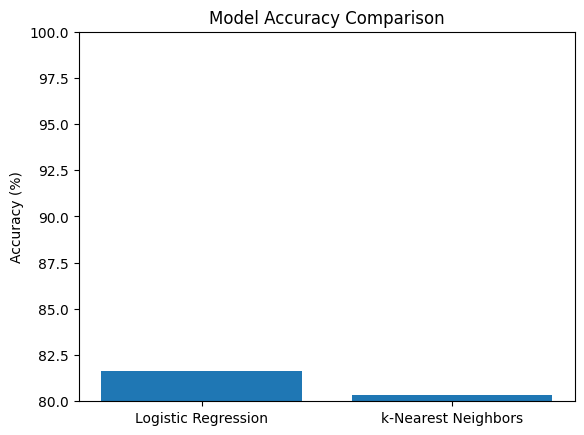

In [58]:
# Step 6: Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
# Step 7: Model Building and Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Logistic Regression model
logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

# k-Nearest Neighbors model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

# Print the accuracy comparison
print("\nAccuracy Comparison:")
print("Logistic Regression Accuracy:", accuracy_logreg * 100, "%")
print("k-Nearest Neighbors Accuracy:", accuracy_knn * 100, "%")
# Step 8: Optional - Plot Accuracy Comparison
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'k-Nearest Neighbors']
accuracies = [accuracy_logreg, accuracy_knn]

plt.bar(models, [a * 100 for a in accuracies])
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.ylim(80, 100)
plt.show()
